In [ ]:
# Importando as bibliotecas necessárias
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
from ucimlrepo import fetch_ucirepo
from scipy.stats import norm

# Carregar o dataset Iris (considerando que o fetch_ucirepo foi utilizado previamente para obter os dados)
# Para fins de exemplo, usaremos um CSV com o mesmo formato dos dados Iris

data = pd.read_csv('iris_data.csv')  # Substitua pelo caminho correto, se necessário

# Exibindo os primeiros registros para garantir que os dados foram carregados corretamente
print(data.head())

# Separar as features (atributos) e os rótulos
X = data.iloc[:, :-1].values  # As 4 primeiras colunas (sepal length, sepal width, petal length, petal width)
y = data.iloc[:, -1].values   # A última coluna contém os rótulos (classes)

# Codificar os rótulos de classe
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Definir os pares de atributos para plotar a superfície de decisão
feature_pairs = [(0, 1), (2, 3)]  # Escolher um par de atributos, neste caso sepal length vs sepal width

# Inicializar variáveis para armazenar acurácias e desvios
num_realizacoes = 20
accuracies = []

# Realizar 20 execuções
for realizacao in range(num_realizacoes):
    # Separar dados de treinamento e teste (80% treino, 20% teste)
    X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=realizacao)
    
    # Inicializar o classificador Naive Bayes Gaussiano
    gnb = GaussianNB()
    
    # Treinar o modelo
    gnb.fit(X_train, y_train)
    
    # Fazer previsões
    y_pred = gnb.predict(X_test)
    
    # Calcular a acurácia
    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)
    
    # Exibir a matriz de confusão para uma das realizações (primeira execução)
    if realizacao == 0:
        print(f"Matriz de confusão - Realização {realizacao + 1}:")
        cm = confusion_matrix(y_test, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
        plt.title('Matriz de Confusão')
        plt.xlabel('Predição')
        plt.ylabel('Real')
        plt.show()

# Calcular a acurácia média e o desvio padrão
mean_accuracy = np.mean(accuracies)
std_accuracy = np.std(accuracies)

print(f"Acurácia média após {num_realizacoes} realizações: {mean_accuracy:.4f}")
print(f"Desvio padrão da acurácia: {std_accuracy:.4f}")

# Função para plotar a superfície de decisão (escolhendo um par de atributos)
def plot_decision_surface(X, y, pair, model):
    x_min, x_max = X[:, pair[0]].min() - 1, X[:, pair[0]].max() + 1
    y_min, y_max = X[:, pair[1]].min() - 1, X[:, pair[1]].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))
    
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    plt.contourf(xx, yy, Z, alpha=0.3, cmap=ListedColormap(('red', 'green', 'blue')))
    plt.scatter(X[:, pair[0]], X[:, pair[1]], c=y, cmap=ListedColormap(('red', 'green', 'blue')))
    plt.xlabel(data.columns[pair[0]])
    plt.ylabel(data.columns[pair[1]])
    plt.title('Superfície de Decisão')
    plt.show()

# Para plotar a superfície de decisão, precisamos treinar o modelo com apenas 2 atributos
X_train_pair, X_test_pair, y_train_pair, y_test_pair = train_test_split(X[:, [0, 1]], y_encoded, test_size=0.2, random_state=0)
# Instanciar o classificador
gnb = GaussianNB()
# Treinar o classificador com as duas features (sepal length e sepal width)
gnb_pair = GaussianNB()
gnb_pair.fit(X_train_pair, y_train_pair)

# Plotar a superfície de decisão para o primeiro par de atributos (sepal length e sepal width)
plot_decision_surface(X[:, [0, 1]], y_encoded, (0, 1), gnb_pair)

# Plotar as gaussianas sobre os dados para cada classe
def plot_gaussians(X_train, y_train, pair, model):
    plt.figure(figsize=(8, 6))
    
    # Para cada classe, vamos plotar a gaussiana
    for idx, class_value in enumerate(np.unique(y_train)):
        class_data = X_train[y_train == class_value]
        plt.scatter(class_data[:, pair[0]], class_data[:, pair[1]], label=label_encoder.classes_[class_value], alpha=0.6)
        
        # Obter as médias e variâncias das distribuições gaussianas ajustadas
        mean = model.theta_[class_value, pair]
        var = model.var_[class_value, pair]  # Substituímos sigma_ por var_
        
        # Plotar elipses que representam as gaussianas
        cov_matrix = np.diag(var)
        plot_gaussian_ellipse(mean, cov_matrix)
    
    plt.xlabel(data.columns[pair[0]])
    plt.ylabel(data.columns[pair[1]])
    plt.title('Distribuição Gaussiana por Classe')
    plt.legend()
    plt.show()

# Função auxiliar para plotar elipses gaussianas
from matplotlib.patches import Ellipse

def plot_gaussian_ellipse(mean, cov_matrix, ax=None, **kwargs):
    if ax is None:
        ax = plt.gca()
    
    eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)
    order = eigenvalues.argsort()[::-1]
    eigenvalues, eigenvectors = eigenvalues[order], eigenvectors[:, order]
    
    angle = np.degrees(np.arctan2(*eigenvectors[:, 0][::-1]))
    width, height = 2 * np.sqrt(eigenvalues)
    
    for nsig in range(1, 3):  # Plota 1, 2-sigma elipses
        ellipse = Ellipse(xy=mean, width=nsig * width, height=nsig * height, angle=angle, **kwargs)
        ax.add_patch(ellipse)

# Plotar as gaussianas sobre o primeiro par de atributos
plot_gaussians(X_train_pair, y_train_pair, (0, 1), gnb_pair)

# Exibir os dados de treinamento e teste utilizados na primeira realização
print("Dados de Treinamento (primeira realização):")
print(X_train)
print("Dados de Teste (primeira realização):")
print(X_test)




In [ ]:
# Importando as bibliotecas necessárias
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
from ucimlrepo import fetch_ucirepo
from scipy.stats import norm

# Carregar o dataset Iris
data = pd.read_csv('iris_data.csv')  # Substitua pelo caminho correto, se necessário

# Exibindo os primeiros registros para garantir que os dados foram carregados corretamente
print(data.head())

# Separar as features (atributos) e os rótulos
X = data.iloc[:, :-1].values
y = data.iloc[:, -1].values

# Codificar os rótulos de classe
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Definir os pares de atributos para plotar a superfície de decisão
feature_pairs = [(0, 1), (2, 3)]

# Inicializar variáveis para armazenar acurácias
num_realizacoes = 20
accuracies = []

# Realizar 20 execuções
for realizacao in range(num_realizacoes):
    # Separar dados de treinamento e teste
    X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=realizacao)
    
    # Inicializar o classificador Naive Bayes Gaussiano
    gnb = GaussianNB()
    
    # Treinar o modelo
    gnb.fit(X_train, y_train)
    
    # Fazer previsões
    y_pred = gnb.predict(X_test)
    
    # Calcular a acurácia
    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)
    
    # Exibir a matriz de confusão para a primeira execução
    if realizacao == 0:
        print(f"Matriz de confusão - Realização {realizacao + 1}:")
        cm = confusion_matrix(y_test, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
        plt.title('Matriz de Confusão')
        plt.xlabel('Predição')
        plt.ylabel('Real')
        plt.show()

# Calcular a acurácia média e o desvio padrão
mean_accuracy = np.mean(accuracies)
std_accuracy = np.std(accuracies)

print(f"Acurácia média após {num_realizacoes} realizações: {mean_accuracy:.4f}")
print(f"Desvio padrão da acurácia: {std_accuracy:.4f}")

# Função para plotar a superfície de decisão
def plot_decision_surface(X, y, pair, model):
    x_min, x_max = X[:, pair[0]].min() - 1, X[:, pair[0]].max() + 1
    y_min, y_max = X[:, pair[1]].min() - 1, X[:, pair[1]].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))
    
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    plt.contourf(xx, yy, Z, alpha=0.3, cmap=ListedColormap(('red', 'green', 'blue')))
    plt.scatter(X[:, pair[0]], X[:, pair[1]], c=y, cmap=ListedColormap(('red', 'green', 'blue')))
    plt.xlabel(data.columns[pair[0]])
    plt.ylabel(data.columns[pair[1]])
    plt.title('Superfície de Decisão')
    plt.show()

# Treinando o modelo com apenas 2 atributos
X_train_pair, X_test_pair, y_train_pair, y_test_pair = train_test_split(X[:, [0, 1]], y_encoded, test_size=0.2, random_state=0)
gnb_pair = GaussianNB()
gnb_pair.fit(X_train_pair, y_train_pair)

# Plotar a superfície de decisão
plot_decision_surface(X[:, [0, 1]], y_encoded, (0, 1), gnb_pair)

# Plotar as gaussianas sobre os dados para cada classe
def plot_gaussians(X_train, y_train, pair, model):
    plt.figure(figsize=(8, 6))
    
    # Para cada classe, vamos plotar a gaussiana
    for idx, class_value in enumerate(np.unique(y_train)):
        class_data = X_train[y_train == class_value]
        plt.scatter(class_data[:, pair[0]], class_data[:, pair[1]], label=label_encoder.classes_[class_value], alpha=0.6)
        
        # Obter as médias e variâncias das distribuições gaussianas ajustadas
        mean = model.theta_[class_value]  # Média
        var = model.var_[class_value]  # Variância
        cov_matrix = np.diag(var)  # Matriz de covariância

        # Plotar elipses que representam as gaussianas
        plot_gaussian_ellipse(mean, cov_matrix)

    plt.xlabel(data.columns[pair[0]])
    plt.ylabel(data.columns[pair[1]])
    plt.title('Distribuição Gaussiana por Classe')
    plt.legend()
    plt.show()

# Função auxiliar para plotar elipses gaussianas
from matplotlib.patches import Ellipse

def plot_gaussian_ellipse(mean, cov_matrix, ax=None, **kwargs):
    if ax is None:
        ax = plt.gca()
    
    eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)
    order = eigenvalues.argsort()[::-1]
    eigenvalues, eigenvectors = eigenvalues[order], eigenvectors[:, order]
    
    angle = np.degrees(np.arctan2(*eigenvectors[:, 0][::-1]))
    width, height = 2 * np.sqrt(eigenvalues)
    
    for nsig in range(1, 3):  # Plota 1, 2-sigma elipses
        ellipse = Ellipse(xy=mean, width=nsig * width, height=nsig * height, angle=angle, **kwargs)
        ax.add_patch(ellipse)

# Plotar as gaussianas sobre o primeiro par de atributos
plot_gaussians(X_train_pair, y_train_pair, (0, 1), gnb_pair)

# Exibir os dados de treinamento e teste utilizados na primeira realização
print("Dados de Treinamento (primeira realização):")
print(X_train_pair)
print("Dados de Teste (primeira realização):")
print(X_test_pair)

# Plotar as distribuições Gaussianas para cada classe
def plot_gaussian_distribution(X, y, model):
    for i, class_label in enumerate(np.unique(y)):
        mean = model.theta_[i]  # Média para a classe i
        std_dev = np.sqrt(model.var_[i])  # Desvio padrão (sqrt da variância) para a classe i
        
        x = np.linspace(X[:, 0].min(), X[:, 0].max(), 100)
        y1 = norm.pdf(x, mean[0], std_dev[0])  # Gaussian para o primeiro atributo
        y2 = norm.pdf(x, mean[1], std_dev[1])  # Gaussian para o segundo atributo

        # Usar as classes decodificadas corretamente
        plt.plot(x, y1, label=f'Classe {label_encoder.inverse_transform([class_label])[0]} - Atributo 1')
        plt.plot(x, y2, label=f'Classe {label_encoder.inverse_transform([class_label])[0]} - Atributo 2')
    
    plt.title('Distribuições Gaussianas por Classe - Iris')
    plt.xlabel('Valor do atributo')
    plt.ylabel('Densidade de probabilidade')
    plt.legend()
    plt.show()

plot_gaussian_distribution(X_train_pair, y_train_pair, gnb_pair)


<h2>Dataset Coluna Vertebral</h2>

In [ ]:
from ucimlrepo import fetch_ucirepo
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import pandas as pd

# Carregar o dataset Coluna Vertebral
vertebral_column = fetch_ucirepo(id=212)
X = vertebral_column.data.features
y = vertebral_column.data.targets

# Codificar rótulos se necessário
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Selecionar um par de atributos para a superfície de decisão
X_pair = X[['pelvic_incidence', 'pelvic_tilt']].values

# Separar dados de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X_pair, y_encoded, test_size=0.3, random_state=42)

# Instanciar e treinar o modelo
gnb = GaussianNB()
gnb.fit(X_train, y_train)

# Prever no conjunto de teste
y_pred = gnb.predict(X_test)

# Avaliar a acurácia e a matriz de confusão
acc = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

print(f"Acurácia: {acc}")
print("Matriz de Confusão:")
print(cm)

# Função para plotar a superfície de decisão
def plot_decision_surface(X, y, model):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))
    
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    plt.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.coolwarm)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm, edgecolors='k')
    plt.xlabel('Pelvic Incidence')
    plt.ylabel('Pelvic Tilt')
    plt.title('Superfície de Decisão - Coluna Vertebral')
    plt.show()

# Plotar a superfície de decisão
plot_decision_surface(X_test, y_test, gnb)


In [ ]:
from ucimlrepo import fetch_ucirepo
import numpy as np
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns

# Carregar dataset Coluna Vertebral
vertebral_column = fetch_ucirepo(id=212)
X = vertebral_column.data.features[['pelvic_incidence', 'pelvic_tilt', 'lumbar_lordosis_angle', 'sacral_slope', 'pelvic_radius', 'degree_spondylolisthesis']]
y = vertebral_column.data.targets

# Codificar rótulos para numéricos
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Escolher um par de atributos
X_pair = X[['pelvic_incidence', 'pelvic_tilt']].values

# Listas para armazenar acurácias
accuracies = []

# Realizar 20 execuções
for i in range(20):
    X_train, X_test, y_train, y_test = train_test_split(X_pair, y_encoded, test_size=0.3, random_state=i)
    
    # Instanciar e treinar o classificador Naive Bayes
    gnb = GaussianNB()
    gnb.fit(X_train, y_train)
    
    # Previsão
    y_pred = gnb.predict(X_test)
    
    # Calcular a acurácia e armazenar
    acc = accuracy_score(y_test, y_pred)
    accuracies.append(acc)

# Calcular a acurácia média e o desvio padrão
mean_acc = np.mean(accuracies)
std_acc = np.std(accuracies)

print(f"Acurácia média: {mean_acc}")
print(f"Desvio padrão: {std_acc}")

# Apresentar a matriz de confusão para uma das execuções (random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X_pair, y_encoded, test_size=0.3, random_state=0)
gnb.fit(X_train, y_train)
y_pred = gnb.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Matriz de Confusão - Coluna Vertebral')
plt.show()

# Plotar a superfície de decisão
def plot_decision_surface(X, y, model):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))
    
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    plt.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.coolwarm)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm, edgecolors='k')
    plt.xlabel('Pelvic Incidence')
    plt.ylabel('Pelvic Tilt')
    plt.title('Superfície de Decisão - Coluna Vertebral')
    plt.show()

# Plotar a superfície de decisão para random_state=0
plot_decision_surface(X_test, y_test, gnb)

# Exibir os dados de treinamento e teste utilizados na primeira realização
print("Dados de Treinamento (primeira realização):")
print(X_train)
print("Dados de Teste (primeira realização):")
print(X_test)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
import seaborn as sns
from ucimlrepo import fetch_ucirepo
from scipy.stats import norm

# Carregar dataset Coluna Vertebral
vertebral_column = fetch_ucirepo(id=212)
X = vertebral_column.data.features[['pelvic_incidence', 'pelvic_tilt', 'lumbar_lordosis_angle', 'sacral_slope', 'pelvic_radius', 'degree_spondylolisthesis']]
y = vertebral_column.data.targets

# Realizar 20 execuções
for i in range(20):
    X_train, X_test, y_train, y_test = train_test_split(X_pair, y_encoded, test_size=0.3, random_state=i)
    
    # Instanciar e treinar o classificador Naive Bayes
    gnb = GaussianNB()
    gnb.fit(X_train, y_train)
    
    # Previsão
    y_pred = gnb.predict(X_test)
    
    # Calcular a acurácia e armazenar
    acc = accuracy_score(y_test, y_pred)
    accuracies.append(acc)
# Calcular a acurácia média e o desvio padrão
from sklearn.metrics import accuracy_score
mean_acc = np.mean(accuracies)
std_acc = np.std(accuracies)

print(f"Acurácia média: {mean_acc}")
print(f"Desvio padrão: {std_acc}")
# Codificar rótulos para numéricos
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Escolher um par de atributos contínuos
X_pair = X[['pelvic_incidence', 'pelvic_tilt']].values

# Instanciar o classificador
gnb = GaussianNB()

# Separar treino e teste (usando um random_state para consistência)
X_train, X_test, y_train, y_test = train_test_split(X_pair, y_encoded, test_size=0.3, random_state=0)

# Treinar o classificador
gnb.fit(X_train, y_train)

# Prever no conjunto de teste
y_pred = gnb.predict(X_test)

# Matriz de confusão
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Matriz de Confusão - Coluna Vertebral')
plt.show()

# Superfície de decisão
def plot_decision_surface(X, y, model):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))
    
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    plt.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.coolwarm)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm, edgecolors='k')
    plt.xlabel('Pelvic Incidence')
    plt.ylabel('Pelvic Tilt')
    plt.title('Superfície de Decisão - Coluna Vertebral')
    plt.show()

plot_decision_surface(X_test, y_test, gnb)

# Plotar as distribuições Gaussianas para cada classe
def plot_gaussian_distribution(X, y, model):
    for i, class_label in enumerate(np.unique(y)):
        mean = model.theta_[i]  # Média para a classe i
        std_dev = np.sqrt(model.var_[i])  # Desvio padrão (sqrt da variância) para a classe i
        
        x = np.linspace(X[:, 0].min(), X[:, 0].max(), 100)
        y1 = norm.pdf(x, mean[0], std_dev[0])  # Gaussian para o primeiro atributo
        y2 = norm.pdf(x, mean[1], std_dev[1])  # Gaussian para o segundo atributo

        plt.plot(x, y1, label=f'Classe {label_encoder.inverse_transform([class_label])[0]} - Pelvic Incidence')
        plt.plot(x, y2, label=f'Classe {label_encoder.inverse_transform([class_label])[0]} - Pelvic Tilt')
    
    plt.title('Distribuições Gaussianas por Classe - Coluna Vertebral')
    plt.xlabel('Valor do atributo')
    plt.ylabel('Densidade de probabilidade')
    plt.legend()
    plt.show()

plot_gaussian_distribution(X_train, y_train, gnb)


<h2>Dataset Cancer de Mama</h2>

In [ ]:
from ucimlrepo import fetch_ucirepo
import numpy as np
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns

# Carregar dataset Breast Cancer
breast_cancer = fetch_ucirepo(id=14)
X = breast_cancer.data.features
y = breast_cancer.data.targets

# Codificar variáveis categóricas e rótulos
X_encoded = X.apply(LabelEncoder().fit_transform)
y_encoded = LabelEncoder().fit_transform(y)

# Escolher um par de atributos
X_pair = X_encoded[['age', 'tumor-size']].values

# Listas para armazenar acurácias
accuracies = []

# Realizar 20 execuções
for i in range(20):
    X_train, X_test, y_train, y_test = train_test_split(X_pair, y_encoded, test_size=0.3, random_state=i)
    
    # Instanciar e treinar o classificador Naive Bayes
    gnb = GaussianNB()
    gnb.fit(X_train, y_train)
    
    # Previsão
    y_pred = gnb.predict(X_test)
    
    # Calcular a acurácia e armazenar
    acc = accuracy_score(y_test, y_pred)
    accuracies.append(acc)

# Calcular a acurácia média e o desvio padrão
mean_acc = np.mean(accuracies)
std_acc = np.std(accuracies)

print(f"Acurácia média: {mean_acc}")
print(f"Desvio padrão: {std_acc}")

# Apresentar a matriz de confusão para uma das execuções (random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X_pair, y_encoded, test_size=0.3, random_state=0)
gnb.fit(X_train, y_train)
y_pred = gnb.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=LabelEncoder().fit_transform(y), yticklabels=LabelEncoder().fit_transform(y))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Matriz de Confusão - Breast Cancer')
plt.show()

# Plotar a superfície de decisão para random_state=0
plot_decision_surface(X_test, y_test, gnb)


C:\Users\jorge\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


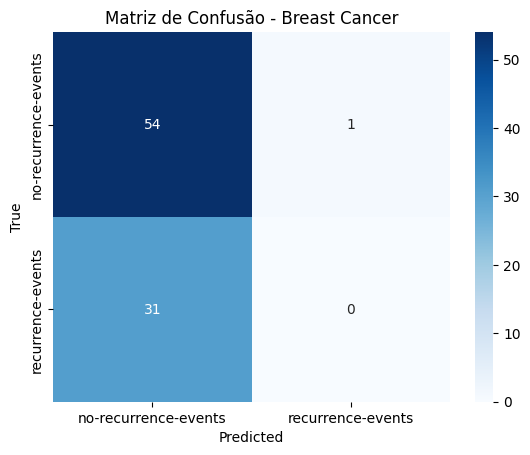

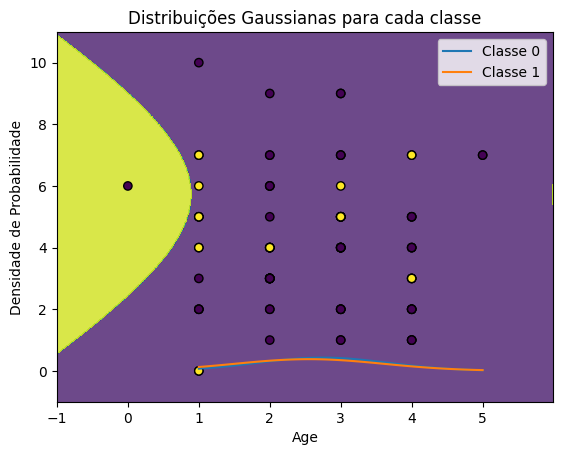

In [5]:
from ucimlrepo import fetch_ucirepo
import numpy as np
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
import seaborn as sns
from scipy.stats import norm

# Carregar dataset Breast Cancer
breast_cancer = fetch_ucirepo(id=14)
X = breast_cancer.data.features
y = breast_cancer.data.targets

# Codificar variáveis categóricas e rótulos
X_encoded = X.apply(LabelEncoder().fit_transform)
y_encoded = LabelEncoder().fit_transform(y)

# Escolher um par de atributos contínuos
X_pair = X_encoded[['age', 'tumor-size']].values

# Instanciar o classificador
gnb = GaussianNB()

# Separar treino e teste
X_train, X_test, y_train, y_test = train_test_split(X_pair, y_encoded, test_size=0.3, random_state=0)

# Treinar o classificador
gnb.fit(X_train, y_train)

# Prever no conjunto de teste
y_pred = gnb.predict(X_test)

# Matriz de confusão
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Matriz de Confusão - Breast Cancer')
plt.show()

# Superfície de decisão
plot_decision_surface(X_test, y_test, gnb)

# Plotar as distribuições Gaussianas para cada classe
plot_gaussian_distribution(X_train, y_train, gnb)


C:\Users\jorge\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


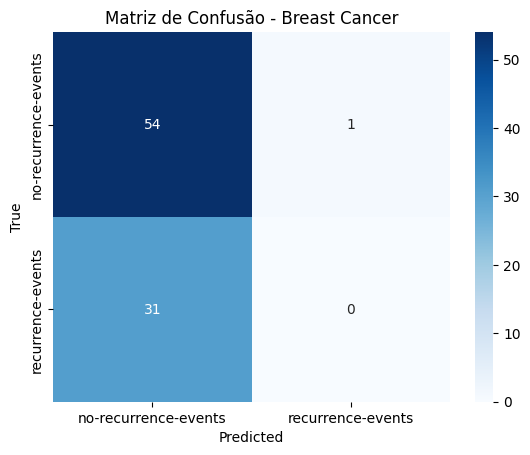

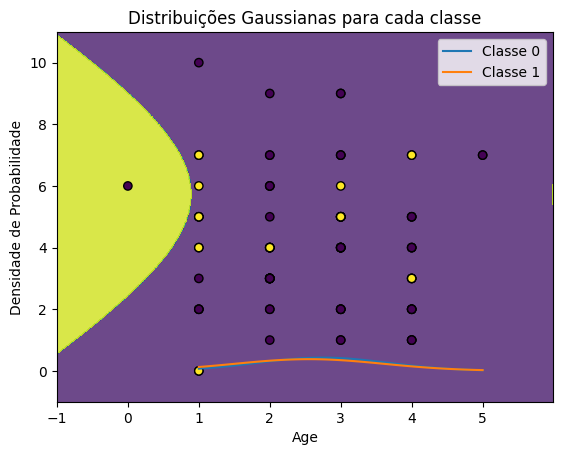

In [4]:
from ucimlrepo import fetch_ucirepo
import numpy as np
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
from scipy.stats import norm

# Carregar dataset Breast Cancer
breast_cancer = fetch_ucirepo(id=14)
X = breast_cancer.data.features
y = breast_cancer.data.targets

# Codificar variáveis categóricas e rótulos
X_encoded = X.apply(LabelEncoder().fit_transform)
y_encoded = LabelEncoder().fit_transform(y)

# Escolher um par de atributos contínuos
X_pair = X_encoded[['age', 'tumor-size']].values

# Instanciar o classificador
gnb = GaussianNB()

# Separar treino e teste
X_train, X_test, y_train, y_test = train_test_split(X_pair, y_encoded, test_size=0.3, random_state=0)

# Treinar o classificador
gnb.fit(X_train, y_train)

# Prever no conjunto de teste
y_pred = gnb.predict(X_test)

# Matriz de confusão
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Matriz de Confusão - Breast Cancer')
plt.show()

# Superfície de decisão
plot_decision_surface(X_test, y_test, gnb)

# Plotar as distribuições Gaussianas para cada classe
plot_gaussian_distribution(X_train, y_train, gnb)


C:\Users\jorge\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Acurácia média: 0.6924418604651162
Desvio padrão: 0.04829082506884902


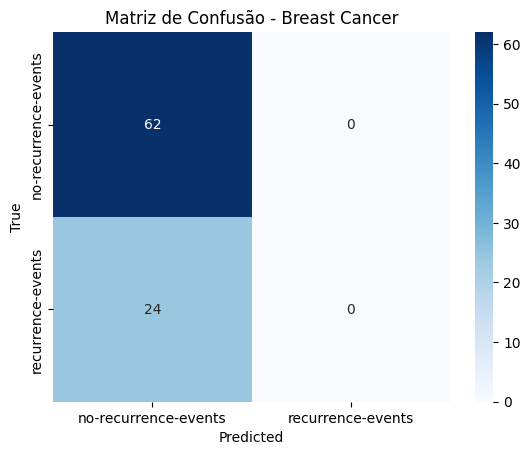

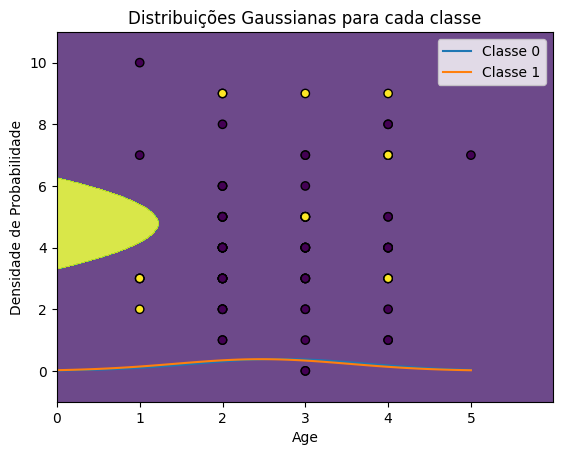

In [3]:
from ucimlrepo import fetch_ucirepo
import numpy as np
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
import seaborn as sns
from scipy.stats import norm

# Carregar dataset Breast Cancer
breast_cancer = fetch_ucirepo(id=14)
X = breast_cancer.data.features
y = breast_cancer.data.targets
# Realizar 20 execuções
for i in range(20):
    X_train, X_test, y_train, y_test = train_test_split(X_pair, y_encoded, test_size=0.3, random_state=i)
    
    # Instanciar e treinar o classificador Naive Bayes
    gnb = GaussianNB()
    gnb.fit(X_train, y_train)
    
    # Previsão
    y_pred = gnb.predict(X_test)
    
    # Calcular a acurácia e armazenar
    acc = accuracy_score(y_test, y_pred)
    accuracies.append(acc)
# Calcular a acurácia média e o desvio padrão
from sklearn.metrics import accuracy_score
mean_acc = np.mean(accuracies)
std_acc = np.std(accuracies)

print(f"Acurácia média: {mean_acc}")
print(f"Desvio padrão: {std_acc}")
# Codificar variáveis categóricas e rótulos
X_encoded = X.apply(LabelEncoder().fit_transform)
y_encoded = LabelEncoder().fit_transform(y)

# Escolher um par de atributos contínuos
X_pair = X_encoded[['age', 'tumor-size']].values

# Instanciar o classificador
gnb = GaussianNB()

# Separar treino e teste
X_train, X_test, y_train, y_test = train_test_split(X_pair, y_encoded, test_size=0.3, random_state=0)

# Treinar o classificador
gnb.fit(X_train, y_train)

# Prever no conjunto de teste
y_pred = gnb.predict(X_test)

# Matriz de confusão
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Matriz de Confusão - Breast Cancer')
plt.show()

# Superfície de decisão
plot_decision_surface(X_test, y_test, gnb)

# Plotar as distribuições Gaussianas para cada classe
plot_gaussian_distribution(X_train, y_train, gnb)


C:\Users\jorge\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Acurácia média: 0.6924418604651164
Desvio padrão: 0.04829082506884902


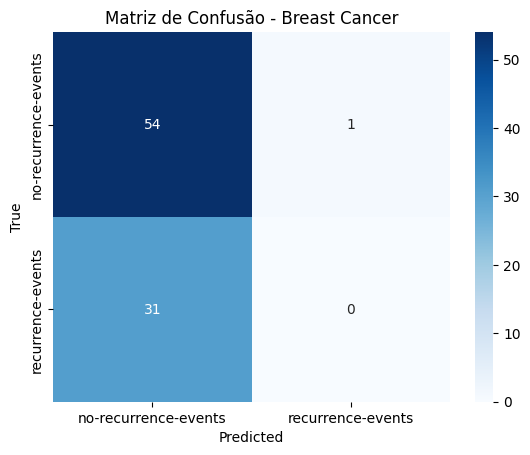

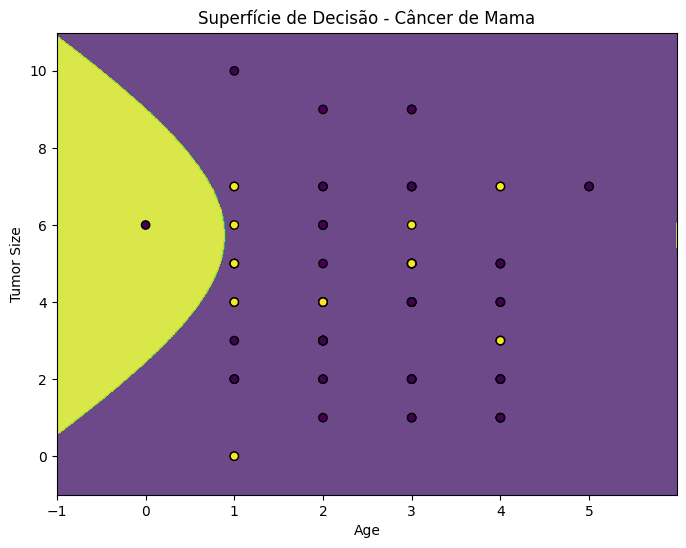

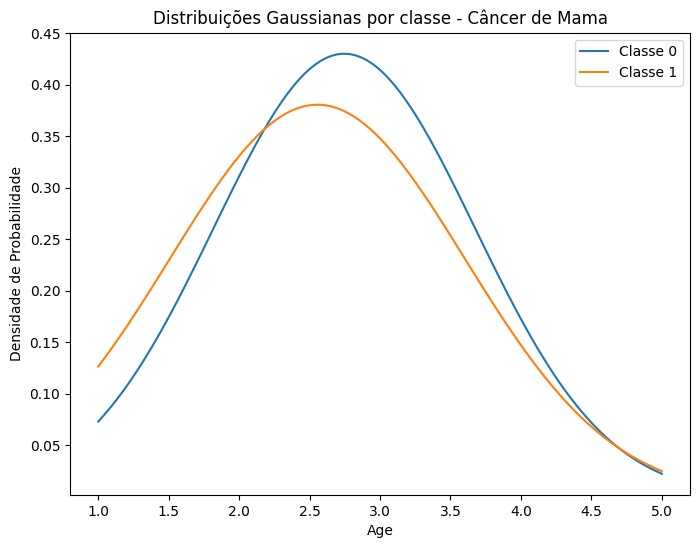

In [7]:
from ucimlrepo import fetch_ucirepo
import numpy as np
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
from scipy.stats import norm

# Carregar dataset Breast Cancer
breast_cancer = fetch_ucirepo(id=14)
X = breast_cancer.data.features
y = breast_cancer.data.targets

# Codificar variáveis categóricas e rótulos
X_encoded = X.apply(LabelEncoder().fit_transform)
y_encoded = LabelEncoder().fit_transform(y)

# Escolher um par de atributos contínuos
X_pair = X_encoded[['age', 'tumor-size']].values

# Lista para armazenar as acurácias
accuracies = []

# Realizar 20 execuções
for i in range(20):
    X_train, X_test, y_train, y_test = train_test_split(X_pair, y_encoded, test_size=0.3, random_state=i)
    
    # Instanciar e treinar o classificador Naive Bayes
    gnb = GaussianNB()
    gnb.fit(X_train, y_train)
    
    # Previsão
    y_pred = gnb.predict(X_test)
    
    # Calcular a acurácia e armazenar
    acc = accuracy_score(y_test, y_pred)
    accuracies.append(acc)

# Calcular a acurácia média e o desvio padrão
mean_acc = np.mean(accuracies)
std_acc = np.std(accuracies)

print(f"Acurácia média: {mean_acc}")
print(f"Desvio padrão: {std_acc}")

# Separar treino e teste novamente para a matriz de confusão
X_train, X_test, y_train, y_test = train_test_split(X_pair, y_encoded, test_size=0.3, random_state=0)

# Treinar o classificador
gnb.fit(X_train, y_train)

# Prever no conjunto de teste
y_pred = gnb.predict(X_test)

# Matriz de confusão
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Matriz de Confusão - Breast Cancer')
plt.show()

# Função para plotar a superfície de decisão
def plot_decision_surface(X, y, model):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                         np.arange(y_min, y_max, 0.01))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    plt.figure(figsize=(8, 6))
    plt.contourf(xx, yy, Z, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', marker='o')
    plt.xlabel('Age')
    plt.ylabel('Tumor Size')
    plt.title('Superfície de Decisão - Câncer de Mama')
    plt.show()

# Plotar a superfície de decisão
plot_decision_surface(X_test, y_test, gnb)

# Função para plotar distribuições gaussianas
def plot_gaussian_distribution(X, y, model):
    classes = np.unique(y)
    plt.figure(figsize=(8, 6))
    for c in classes:
        # Obter os dados da classe c
        X_c = X[y == c]
        # Ajustar uma distribuição gaussiana
        mu = model.theta_[c]
        sigma = np.sqrt(model.var_[c])
        # Gerar valores para a distribuição
        x = np.linspace(X[:, 0].min(), X[:, 0].max(), 100)
        y_gaussian = norm.pdf(x, mu[0], sigma[0])
        plt.plot(x, y_gaussian, label=f'Classe {c}')
    
    plt.title('Distribuições Gaussianas por classe - Câncer de Mama')
    plt.xlabel('Age')
    plt.ylabel('Densidade de Probabilidade')
    plt.legend()
    plt.show()

# Plotar as distribuições Gaussianas para cada classe
plot_gaussian_distribution(X_train, y_train, gnb)


<h2>Dataset Dermatológico</h2>

In [ ]:
from ucimlrepo import fetch_ucirepo
import numpy as np
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns

# Carregar dataset Dermatology
dermatology = fetch_ucirepo(id=33)
X = dermatology.data.features
y = dermatology.data.targets

# Codificar rótulos
X_encoded = X.apply(LabelEncoder().fit_transform)
y_encoded = LabelEncoder().fit_transform(y)

# Escolher um par de atributos
X_pair = X_encoded[['erythema', 'scaling']].values

# Listas para armazenar acurácias
accuracies = []

# Realizar 20 execuções
for i in range(20):
    X_train, X_test, y_train, y_test = train_test_split(X_pair, y_encoded, test_size=0.3, random_state=i)
    
    # Instanciar e treinar o classificador Naive Bayes
    gnb = GaussianNB()
    gnb.fit(X_train, y_train)
    
    # Previsão
    y_pred = gnb.predict(X_test)
    
    # Calcular a acurácia e armazenar
    acc = accuracy_score(y_test, y_pred)
    accuracies.append(acc)

# Calcular a acurácia média e o desvio padrão
from sklearn.metrics import accuracy_score
mean_acc = np.mean(accuracies)
std_acc = np.std(accuracies)

print(f"Acurácia média: {mean_acc}")
print(f"Desvio padrão: {std_acc}")

# Apresentar a matriz de confusão para uma das execuções (random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X_pair, y_encoded, test_size=0.3, random_state=0)
gnb.fit(X_train, y_train)
y_pred = gnb.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=LabelEncoder().fit_transform(y), yticklabels=LabelEncoder().fit_transform(y))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Matriz de Confusão - Dermatology')
plt.show()

# Plotar a superfície de decisão para random_state=0
plot_decision_surface(X_test, y_test, gnb)


In [ ]:
from ucimlrepo import fetch_ucirepo
import numpy as np
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
import seaborn as sns
from scipy.stats import norm

# Carregar dataset Dermatology
dermatology = fetch_ucirepo(id=33)
X = dermatology.data.features
y = dermatology.data.targets

# Codificar variáveis categóricas e rótulos
X_encoded = X.apply(LabelEncoder().fit_transform)
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Escolher um par de atributos contínuos
X_pair = X_encoded[['erythema', 'scaling']].values

# Instanciar o classificador
gnb = GaussianNB()

# Separar treino e teste
X_train, X_test, y_train, y_test = train_test_split(X_pair, y_encoded, test_size=0.3, random_state=0)

# Treinar o classificador
gnb.fit(X_train, y_train)

# Prever no conjunto de teste
y_pred = gnb.predict(X_test)

# Listas para armazenar acurácias
accuracies = []

# Realizar 20 execuções
for i in range(20):
    X_train, X_test, y_train, y_test = train_test_split(X_pair, y_encoded, test_size=0.3, random_state=i)
    
    # Instanciar e treinar o classificador Naive Bayes
    gnb = GaussianNB()
    gnb.fit(X_train, y_train)
    
    # Previsão
    y_pred = gnb.predict(X_test)
    
    # Calcular a acurácia e armazenar
    acc = accuracy_score(y_test, y_pred)
    accuracies.append(acc)
# Calcular a acurácia média e o desvio padrão
from sklearn.metrics import accuracy_score
mean_acc = np.mean(accuracies)
std_acc = np.std(accuracies)

print(f"Acurácia média: {mean_acc}")
print(f"Desvio padrão: {std_acc}")

# Matriz de confusão
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Matriz de Confusão - Dermatology')
plt.show()

# Superfície de decisão
def plot_decision_surface(X, y, model):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))
    
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    plt.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.coolwarm)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm, edgecolors='k')
    plt.xlabel('Erythema')
    plt.ylabel('Scaling')
    plt.title('Superfície de Decisão - Dermatology')
    plt.show()

plot_decision_surface(X_test, y_test, gnb)

# Plotar as distribuições Gaussianas para cada classe
def plot_gaussian_distribution(X, y, model):
    for i, class_label in enumerate(np.unique(y)):
        mean = model.theta_[i]  # Média para a classe i
        std_dev = np.sqrt(model.var_[i])  # Desvio padrão (sqrt da variância) para a classe i
        
        x = np.linspace(X[:, 0].min(), X[:, 0].max(), 100)
        y1 = norm.pdf(x, mean[0], std_dev[0])  # Gaussian para o primeiro atributo
        y2 = norm.pdf(x, mean[1], std_dev[1])  # Gaussian para o segundo atributo

        # Usar as classes decodificadas corretamente
        plt.plot(x, y1, label=f'Classe {label_encoder.inverse_transform([class_label])[0]} - Erythema')
        plt.plot(x, y2, label=f'Classe {label_encoder.inverse_transform([class_label])[0]} - Scaling')
    
    plt.title('Distribuições Gaussianas por Classe - Dermatology')
    plt.xlabel('Valor do atributo')
    plt.ylabel('Densidade de probabilidade')
    plt.legend()
    plt.show()

plot_gaussian_distribution(X_train, y_train, gnb)


<h2>Dataset Artificial</h2>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix, accuracy_score
from scipy.stats import norm

# Carregar o dataset artificial
artificial_data = pd.read_csv('dados_artificiais_novas_classes.csv')
X = artificial_data[['Feature1', 'Feature2']].values
y = artificial_data['label'].values

# Dividir os dados em conjunto de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Treinar o classificador Naive Bayes
gnb = GaussianNB()
gnb.fit(X_train, y_train)

# Fazer previsões
y_pred = gnb.predict(X_test)

# Calcular a acurácia
accuracy = accuracy_score(y_test, y_pred)
print(f'Acurácia: {accuracy:.2f}')

# Gerar e exibir a matriz de confusão
conf_matrix = confusion_matrix(y_test, y_pred)
print("Matriz de Confusão:")
print(conf_matrix)

# Função para plotar a superfície de decisão
def plot_decision_surface(X, y, model):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                         np.arange(y_min, y_max, 0.01))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, alpha=0.3, cmap='viridis')
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolor='k', cmap='viridis')
    plt.xlabel('Feature1')
    plt.ylabel('Feature2')
    plt.title('Superfície de Decisão - Dados Artificiais')
    plt.show()

# Plotar a superfície de decisão
plot_decision_surface(X_test, y_test, gnb)

# Função para plotar a distribuição gaussiana para cada classe
def plot_gaussian_distribution(X, y, model):
    classes = np.unique(y)
    x = np.linspace(X[:, 0].min(), X[:, 0].max(), 100)
    
    plt.figure(figsize=(12, 6))
    for class_label in classes:
        # Obter média e variância da classe
        mean = model.theta_[class_label - 1]  # Classe começa em 1, índice começa em 0
        var = model.var_[class_label - 1]      # Variância

        # Calcular a distribuição gaussiana para cada atributo
        y1 = norm.pdf(x, mean[0], np.sqrt(var[0]))  # Atributo 1
        y2 = norm.pdf(x, mean[1], np.sqrt(var[1]))  # Atributo 2
        
        plt.plot(x, y1, label=f'Classe {class_label} - Feature1')
        plt.plot(x, y2, label=f'Classe {class_label} - Feature2')
    
    plt.title('Distribuições Gaussianas por Classe - Dados Artificiais')
    plt.legend()
    plt.show()

# Plotar as distribuições Gaussianas
plot_gaussian_distribution(X_train, y_train, gnb)


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay
from scipy.stats import norm

# Carregar o dataset artificial
artificial_data = pd.read_csv('dados_artificiais_novas_classes.csv')
X = artificial_data[['Feature1', 'Feature2']].values
y = artificial_data['label'].values

# Definir o número de iterações
num_iterations = 20
accuracies = []

for i in range(num_iterations):
    # Dividir os dados em conjunto de treinamento e teste
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=i)

    # Treinar o classificador Naive Bayes
    gnb = GaussianNB()
    gnb.fit(X_train, y_train)

    # Fazer previsões
    y_pred = gnb.predict(X_test)

    # Calcular a acurácia e armazená-la
    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)

# Calcular a acurácia média e o desvio padrão
mean_accuracy = np.mean(accuracies)
std_dev_accuracy = np.std(accuracies)

print(f'Acurácia Média: {mean_accuracy:.2f}')
print(f'Desvio Padrão da Acurácia: {std_dev_accuracy:.2f}')

# Gerar e exibir a matriz de confusão para a última iteração
conf_matrix = confusion_matrix(y_test, y_pred)
print("Matriz de Confusão:")
print(conf_matrix)

# Plotar a matriz de confusão
def plot_confusion_matrix(conf_matrix):
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
    disp.plot(cmap='viridis')
    plt.title('Matriz de Confusão')
    plt.show()

# Plotar a matriz de confusão
plot_confusion_matrix(conf_matrix)

# Função para plotar a superfície de decisão
def plot_decision_surface(X, y, model):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                         np.arange(y_min, y_max, 0.01))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, alpha=0.3, cmap='viridis')
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolor='k', cmap='viridis')
    plt.xlabel('Feature1')
    plt.ylabel('Feature2')
    plt.title('Superfície de Decisão - Dados Artificiais')
    plt.show()

# Plotar a superfície de decisão usando o último modelo treinado
plot_decision_surface(X_test, y_test, gnb)

# Função para plotar a distribuição gaussiana para cada classe
def plot_gaussian_distribution(X, y, model):
    classes = np.unique(y)
    x = np.linspace(X[:, 0].min(), X[:, 0].max(), 100)
    
    plt.figure(figsize=(12, 6))
    for class_label in classes:
        # Obter média e variância da classe
        mean = model.theta_[class_label - 1]  # Classe começa em 1, índice começa em 0
        var = model.var_[class_label - 1]      # Variância

        # Calcular a distribuição gaussiana para cada atributo
        y1 = norm.pdf(x, mean[0], np.sqrt(var[0]))  # Atributo 1
        y2 = norm.pdf(x, mean[1], np.sqrt(var[1]))  # Atributo 2
        
        plt.plot(x, y1, label=f'Classe {class_label} - Feature1')
        plt.plot(x, y2, label=f'Classe {class_label} - Feature2')
    
    plt.title('Distribuições Gaussianas por Classe - Dados Artificiais')
    plt.legend()
    plt.show()

# Plotar as distribuições Gaussianas usando o conjunto de treinamento
plot_gaussian_distribution(X_train, y_train, gnb)
